# Using `xarray` to parse the data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rasterio
import rioxarray
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

from src.dnbr import apply_bit_mask_group, apply_bitmask

In [3]:
# Get list of files
sherlock_path = "landsat_c2l2_both/"
paths_to_post = list(Path(sherlock_path).rglob("*.nc4"))

### Open the dataset

In [11]:
ds = (
    xr.open_dataset(paths_to_post[170])
    .to_array() # transform to an array rather than the xr.Dataset
    .squeeze()  # just like in numpy, remove all singletons
)
ds

<xarray.DataArray (time: 5, band: 6, y: 266, x: 168)>
array([[[[11632., 11664., 11695., ...,  9277.,  9331.,  9288.],
         [11748., 11739., 11668., ...,  9009.,  9042.,  9063.],
         [12642., 11859., 11521., ...,  9280.,  9296.,  9244.],
         ...,
         [13623., 13766., 13744., ..., 10262., 10621., 10536.],
         [13675., 13905., 14138., ..., 10366., 10458., 10321.],
         [13569., 13738., 14148., ..., 10389., 10382., 10334.]],

        [[13647., 13757., 13921., ..., 10687., 10613., 10403.],
         [13752., 13857., 13802., ..., 10237., 10371., 10301.],
         [15163., 14266., 13815., ..., 10523., 10525., 10515.],
         ...,
         [15082., 15389., 15452., ..., 12138., 12406., 12559.],
         [15153., 15421., 15677., ..., 12445., 12487., 12422.],
         [15015., 15217., 15648., ..., 12480., 12514., 12527.]],

        [[15117., 15137., 15415., ..., 10578., 10556., 10383.],
         [15455., 15296., 15377., ...,  9969., 10050., 10002.],
         [16896., 15797., 15399., ..., 10324., 10207., 10211.],
         ...,
...
         ...,
         [18737., 19171., 19275., ..., 16084., 17643., 17311.],
         [18358., 18575., 18962., ..., 17670., 17880., 16989.],
         [18112., 18489., 18959., ..., 18351., 18360., 18198.]],

        [[20397., 19411., 19855., ..., 12950., 13031., 13129.],
         [21274., 20193., 20142., ..., 13023., 13135., 13282.],
         [22318., 21625., 21295., ..., 12895., 13084., 13233.],
         ...,
         [21264., 21799., 21378., ..., 18356., 19154., 19093.],
         [20530., 20724., 20731., ..., 19973., 19625., 19332.],
         [20051., 20311., 20827., ..., 20264., 20302., 20447.]],

        [[ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         ...,
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.]]]])
Coordinates: (12/17)
  * time                      (time) datetime64[ns] 1998-07-21T18:18:11.81908...
    id                        (time) object ...
  * band                      (band) object 'blue' 'green' ... 'qa_pixel'
  * x                         (x) float64 -120.8 -120.8 -120.8 ... -120.8 -120.8
  * y                         (y) float64 36.92 36.92 36.92 ... 36.85 36.85
    landsat:cloud_cover_land  (time) float64 ...
    ...                        ...
    eo:cloud_cover            (time) float64 ...
    title                     (band) object ...
    common_name               (band) object ...
    full_width_half_max       (band) float64 ...
    epsg                      int64 ...
    variable                  <U42 'stackstac-fe864c4402f18eb3f37ef339a43842ee'

### Slicing and selecting data

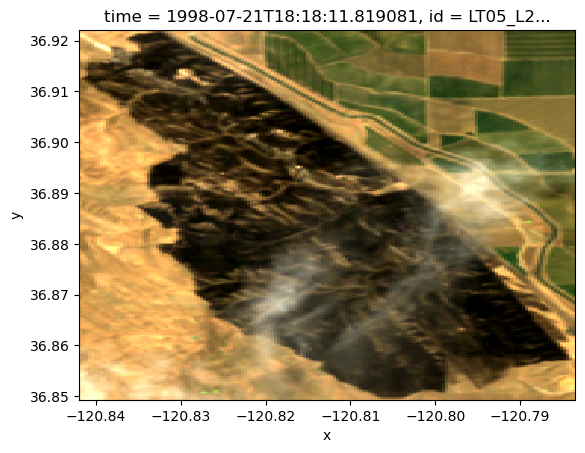

In [12]:
ds.sel(band=["red", "green", "blue"]).isel(time=0).plot.imshow(robust=True)

### You can also aggregate across the time dimension and get a composite

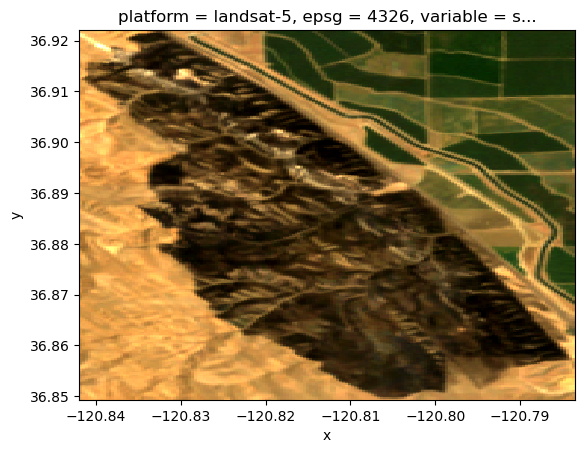

In [13]:
ds.median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True)

Often with composites, we want to solve issues like cloud coverage or bad pixels, but is good to do some QA cleaning per each satellite type. 

In [14]:
ds_clean = apply_bit_mask_group(ds).compute()

Exception: len() of unsized object. Maybe platform length is zero: landsat-5


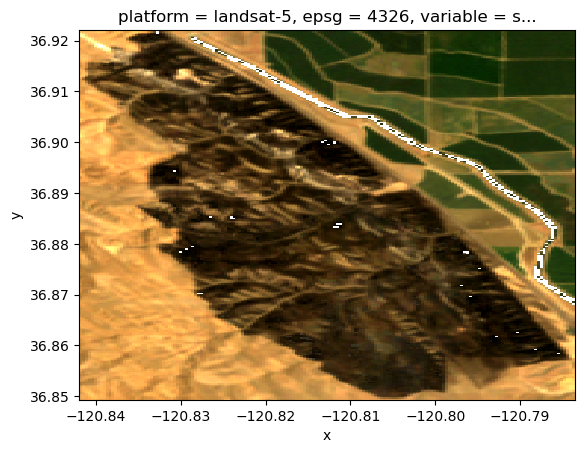

In [15]:
ds_clean.compute().median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True)

## Exploring geographical data in Python

Spatial data can be stored in many different ways! Most vector data (i.e. shapes, lines, etc.) are stored in Shapefiles (`.shp`). The easiest and more pythonic way to deal with this data is by using `geopandas`. Just like `pandas`, you have the data in a `DataFrame` and you can do the same methods and functions. 


In [16]:
# Open the MTBS data, this is the same data you get from the MTBS webpage
mtbs = gpd.read_file("/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD/")
wildfires_ca = mtbs[(mtbs.Event_ID.str.contains("CA") & (mtbs.Incid_Type == "Wildfire"))]
wildfires_ca.head(10)

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CA3370911761819840126,NaN,MODJESKA,Wildfire,10005362,MTBS,Extended (SS),1266,33.708,-117.639,...,504003719840323,-9999,-9999,9999,9999,150,-70,-170,NaN,"MULTIPOLYGON (((-117.64264 33.70811, -117.6424..."
3,CA3607412018819840329,NaN,FK 1817,Wildfire,4557,MTBS,Initial (SS),1462,36.074,-120.188,...,NaN,-9999,-9999,9999,9999,-65,-280,-9999,Single scene assessment,"POLYGON ((-120.18164 36.05393, -120.18211 36.0..."
7,CA3268211688619840421,NaN,PROCTOR,Wildfire,4637,MTBS,Initial,3021,32.682,-116.886,...,NaN,38,-9999,-970,-150,130,359,630,NaN,"POLYGON ((-116.89745 32.69498, -116.89574 32.6..."
12,CA3480712050119840507,NaN,MINUTEMAN,Wildfire,4630,MTBS,Initial (SS),3159,34.807,-120.501,...,NaN,-9999,-9999,9999,9999,-25,-265,-9999,Single scene assessment,"POLYGON ((-120.47030 34.79960, -120.47065 34.7..."
13,CA3433111896419840507,NaN,GRIMES FIRE,Wildfire,4645,MTBS,Initial (SS),10917,34.331,-118.964,...,NaN,-9999,-9999,9999,9999,20,-300,-9999,Single scene assessment,"POLYGON ((-118.99636 34.34969, -118.99589 34.3..."
14,CA3470111707519840512,NaN,STODDARD 2,Wildfire,4565,MTBS,Initial (SS),2458,34.701,-117.075,...,NaN,-9999,-9999,9999,9999,-50,-190,-9999,NaN,"POLYGON ((-117.06736 34.70991, -117.06670 34.7..."
18,CA3709812116219840521,NaN,COTTONWOOD,Wildfire,4636,MTBS,Initial (SS),1409,37.098,-121.162,...,NaN,-9999,-9999,9999,9999,40,-275,-9999,NaN,"POLYGON ((-121.17551 37.10310, -121.17165 37.1..."
20,CA3589912013419840525,NaN,FLAT TOP,Wildfire,4632,MTBS,Initial (SS),6693,35.899,-120.134,...,NaN,-9999,-9999,9999,9999,-65,-9999,-9999,Single scene assessment,"POLYGON ((-120.13213 35.85674, -120.13275 35.8..."
21,CA3626012031719840525,NaN,OIL FIELDS,Wildfire,4633,MTBS,Initial (SS),1136,36.260,-120.317,...,NaN,-9999,-9999,9999,9999,-50,-212,-9999,NaN,"POLYGON ((-120.31646 36.23937, -120.31752 36.2..."
22,CA3561111844619840526,NaN,WOODROW,Wildfire,4558,MTBS,Initial (SS),1118,35.611,-118.446,...,NaN,-9999,-9999,9999,9999,-25,-145,-225,NaN,"POLYGON ((-118.43784 35.60767, -118.43830 35.6..."


We need to project our spatial data (MTBS) to align to the same projection space as our remote-sense data. To do this, we are going to use the Mercator projection (WGS84), which has the EPSG code `4326`. If all this sounds weird, please read [this](https://geohackweek.github.io/visualization/02-projections/) and learn more about projections and why we care about them. 

In Linear Algebra terms, we are doing an affine transform to a grid, so that's all projecting is doing! 

In [17]:
wildfires_ca = wildfires_ca.to_crs("EPSG:4326")

Notice that the `Event_ID` column corresponds to the file names we have in the bucket. If you want more info on the fire we are looking, just do:

(Notice the tricks the `Path` class has `:-)` )

In [18]:
wildfires_ca[wildfires_ca.Event_ID == paths_to_post[170].stem].iloc[0]

Event_ID                                  CA3688212081319980710
irwinID                                                     NaN
Incid_Name                                                MERCY
Incid_Type                                             Wildfire
Map_ID                                                    10088
Map_Prog                                                   MTBS
Asmnt_Type                                              Initial
BurnBndAc                                                  5005
BurnBndLat                                               36.882
BurnBndLon                                             -120.813
Ig_Date                                              1998-07-10
Pre_ID                                          504303419970803
Post_ID                                         504303419980806
Perim_ID                                                    NaN
dNBR_offst                                                   -1
dNBR_stdDv                              

### Masking and extracting data

One of the things you can do with the array data is to clip and extract data to your desire extent. A helpful library for this is `rioxarray`, which combines the powers of `rasterio` (the default raster library in Python) with `xarray` (the default multi-dimensional data library in Python).

In [19]:
wildfires_ca.BurnBndAc.mean()

12835.310483870968

In [25]:
ds = (
    xr.open_dataset(paths_to_post[170])
    .to_array() # transform to an array rather than the xr.Dataset
    .squeeze()  # just like in numpy, remove all singletons
)
ds.rio.set_crs(4326)
ds

<xarray.DataArray (time: 5, band: 6, y: 266, x: 168)>
array([[[[11632., 11664., 11695., ...,  9277.,  9331.,  9288.],
         [11748., 11739., 11668., ...,  9009.,  9042.,  9063.],
         [12642., 11859., 11521., ...,  9280.,  9296.,  9244.],
         ...,
         [13623., 13766., 13744., ..., 10262., 10621., 10536.],
         [13675., 13905., 14138., ..., 10366., 10458., 10321.],
         [13569., 13738., 14148., ..., 10389., 10382., 10334.]],

        [[13647., 13757., 13921., ..., 10687., 10613., 10403.],
         [13752., 13857., 13802., ..., 10237., 10371., 10301.],
         [15163., 14266., 13815., ..., 10523., 10525., 10515.],
         ...,
         [15082., 15389., 15452., ..., 12138., 12406., 12559.],
         [15153., 15421., 15677., ..., 12445., 12487., 12422.],
         [15015., 15217., 15648., ..., 12480., 12514., 12527.]],

        [[15117., 15137., 15415., ..., 10578., 10556., 10383.],
         [15455., 15296., 15377., ...,  9969., 10050., 10002.],
         [16896., 15797., 15399., ..., 10324., 10207., 10211.],
         ...,
...
         ...,
         [18737., 19171., 19275., ..., 16084., 17643., 17311.],
         [18358., 18575., 18962., ..., 17670., 17880., 16989.],
         [18112., 18489., 18959., ..., 18351., 18360., 18198.]],

        [[20397., 19411., 19855., ..., 12950., 13031., 13129.],
         [21274., 20193., 20142., ..., 13023., 13135., 13282.],
         [22318., 21625., 21295., ..., 12895., 13084., 13233.],
         ...,
         [21264., 21799., 21378., ..., 18356., 19154., 19093.],
         [20530., 20724., 20731., ..., 19973., 19625., 19332.],
         [20051., 20311., 20827., ..., 20264., 20302., 20447.]],

        [[ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         ...,
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.],
         [ 5440.,  5440.,  5440., ...,  5440.,  5440.,  5440.]]]])
Coordinates: (12/17)
  * time                      (time) datetime64[ns] 1998-07-21T18:18:11.81908...
    id                        (time) object ...
  * band                      (band) object 'blue' 'green' ... 'qa_pixel'
  * x                         (x) float64 -120.8 -120.8 -120.8 ... -120.8 -120.8
  * y                         (y) float64 36.92 36.92 36.92 ... 36.85 36.85
    landsat:cloud_cover_land  (time) float64 ...
    ...                        ...
    eo:cloud_cover            (time) float64 ...
    title                     (band) object ...
    common_name               (band) object ...
    full_width_half_max       (band) float64 ...
    epsg                      int64 ...
    variable                  <U42 'stackstac-fe864c4402f18eb3f37ef339a43842ee'

<Axes: title={'center': 'platform = landsat-5, epsg = 4326, variable = s...'}, xlabel='x', ylabel='y'>

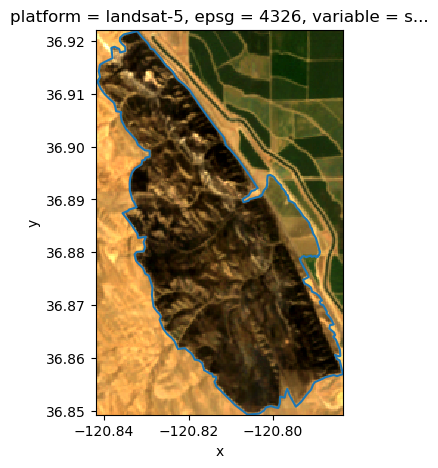

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
ds.median(dim="time").sel(band=["red", "green", "blue"]).plot.imshow(robust=True, ax=ax)

# Plot the boundary of the polygon, not the whole polygon
wildfires_ca[wildfires_ca.Event_ID == paths_to_post[170].stem].geometry.boundary.plot(ax=ax)

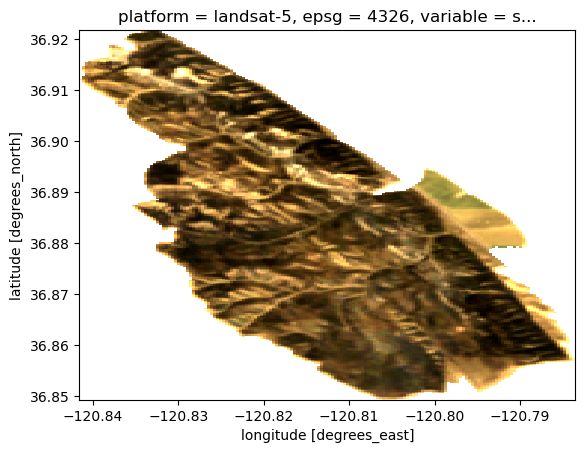

In [28]:
clipped = ds.rio.clip(wildfires_ca[wildfires_ca.Event_ID == paths_to_post[170].stem].geometry)
clipped_median = clipped.median(dim="time")
clipped_median.sel(band=["red", "green", "blue"]).plot.imshow(robust=True)

In [29]:
clipped_median.rio.to_raster("test_raster_file.tif")